In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("data").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/15 12:57:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pathlib import Path
lymsys_folder = Path("/Users/hamzaboukhriss/Desktop/Bigdata/lymsys")
wildchat_folder = Path("/Users/hamzaboukhriss/Desktop/Bigdata/wildchat")

In [68]:

lymsys_df = spark.read.parquet(str(lymsys_folder))
wildchat_df1 = spark.read.parquet(str(wildchat_folder))

wildchat_df = wildchat_df1.unionByName(lymsys_df, allowMissingColumns=True)
wildchat_df.show(5)

+--------------------+------------------+-------------------+---------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+---------------+
|   conversation_hash|             model|          timestamp|                     conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|        state|        country|           hashed_ip|              header|conversation_id|
+--------------------+------------------+-------------------+---------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+---------------+
|f01a345e668b978b6...|gpt-3.5-turbo-0613|2023-09-13 04:14:27|             [{(In the clubroo...|   1| English|[{{false, false, ...|[{2.1957975695841...|false|   false|     Michigan|  United States|f96c8515aa663db23...|{en-US,en;q=0.9, .

In [8]:
from pyspark.sql.functions import when

# Create a column to assign device type based on user-agent (desktop vs mobile)
a_df = wildchat_df.withColumn(
	"device_type",
	when(
		F.lower(F.col("header.user-agent")).like("%mobile%"),
		"mobile"
	).otherwise("desktop")
)



a_df.show(16)


+--------------------+------------------+-------------------+-----------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+---------------+-----------+
|   conversation_hash|             model|          timestamp|                       conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|        state|        country|           hashed_ip|              header|conversation_id|device_type|
+--------------------+------------------+-------------------+-----------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+---------------+-----------+
|f01a345e668b978b6...|gpt-3.5-turbo-0613|2023-09-13 04:14:27|               [{(In the clubroo...|   1| English|[{{false, false, ...|[{2.1957975695841...|false|   false|     Michigan|  United St

In [9]:
# Count the number of person using desktop and mobile as a device 
device_counts = a_df.groupBy("device_type").count()

device_counts.show()

+-----------+-------+
|device_type|  count|
+-----------+-------+
|    desktop|1765538|
|     mobile| 169813|
+-----------+-------+



In [13]:
#regional Preferences  
device_by_country_pivot = a_df.groupBy("country") \
    .pivot("device_type", ["mobile", "desktop"]) \
    .count() \
    .fillna(0) 

device_by_country_pivot.show()



+--------------------+------+-------+
|             country|mobile|desktop|
+--------------------+------+-------+
|              Russia| 25067| 111711|
|            Paraguay|    25|     35|
|               Macao|   301|    771|
|               Yemen|   429|    516|
|             Senegal|     4|     39|
|              Sweden|   283|   1454|
|          Cabo Verde|     1|      3|
|     The Netherlands|  2554|   7742|
|              Guyana|     0|     36|
|         Philippines|  2430|   7428|
|             Eritrea|     2|      5|
|              Jersey|     1|      0|
|            Djibouti|     0|      1|
|           Singapore|  1223|  11514|
|            Malaysia|   449|   3204|
|                Fiji|     1|     15|
|              Malawi|     1|      4|
|                Iraq|   335|    540|
|             Germany|  2906|  31575|
|Northern Mariana ...|     2|      0|
+--------------------+------+-------+
only showing top 20 rows



In [15]:
from pyspark.sql.functions import expr

# Calculate the percentage of mobile and desktop usage
# Add a column for the total number of devices per country
device_by_country_pivot = device_by_country_pivot.withColumn(
    "total_devices", 
    expr("mobile + desktop")
)

# Add a column for the percentage of mobile usage
device_by_country_pivot = device_by_country_pivot.withColumn(
    "mobile_percentage", 
    (F.col("mobile") / F.col("total_devices") * 100).cast("double")
)

# Add a column for the percentage of desktop usage
device_by_country_pivot = device_by_country_pivot.withColumn(
    "desktop_percentage", 
    (100 - F.col("mobile_percentage")).cast("double")
)

# Show the result
device_by_country_pivot.show()


+--------------------+------+-------+-------------+------------------+------------------+
|             country|mobile|desktop|total_devices| mobile_percentage|desktop_percentage|
+--------------------+------+-------+-------------+------------------+------------------+
|              Russia| 25067| 111711|       136778|18.326777698167835| 81.67322230183217|
|            Paraguay|    25|     35|           60| 41.66666666666667| 58.33333333333333|
|               Macao|   301|    771|         1072|28.078358208955223| 71.92164179104478|
|               Yemen|   429|    516|          945|  45.3968253968254|  54.6031746031746|
|             Senegal|     4|     39|           43|  9.30232558139535| 90.69767441860465|
|              Sweden|   283|   1454|         1737| 16.29245826137018| 83.70754173862983|
|          Cabo Verde|     1|      3|            4|              25.0|              75.0|
|     The Netherlands|  2554|   7742|        10296|24.805749805749805|  75.1942501942502|
|         

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


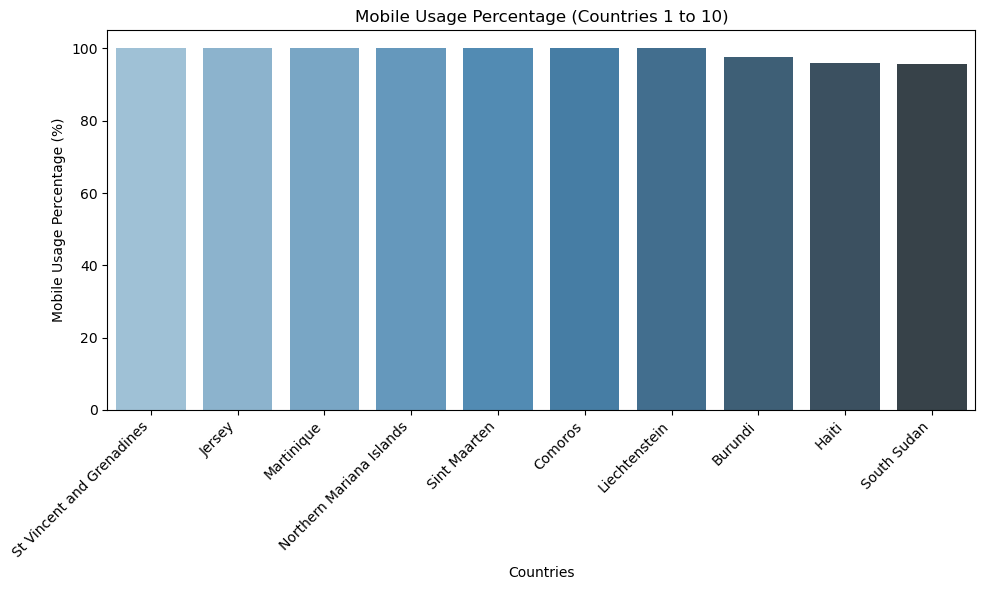

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


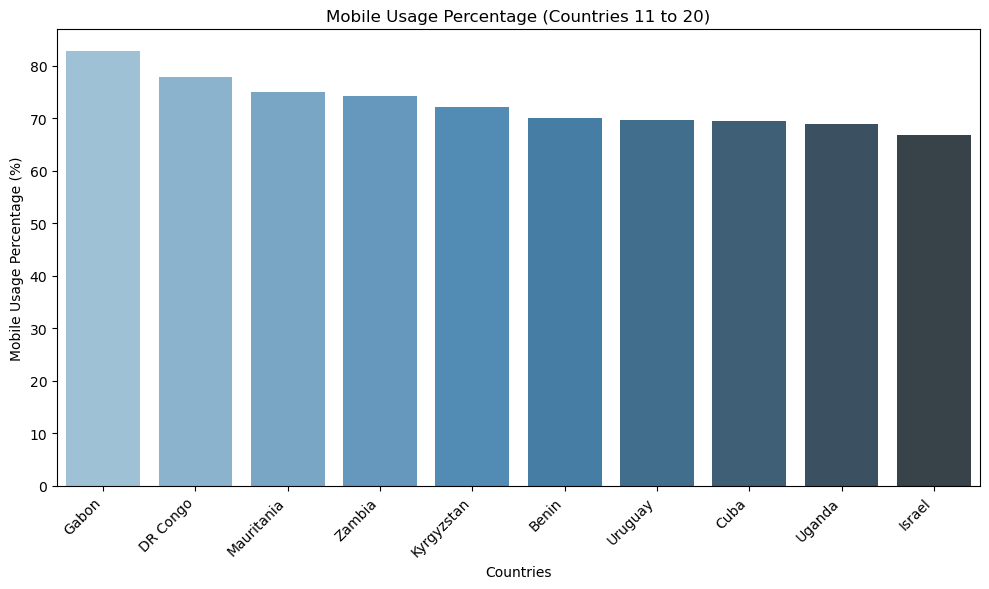

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


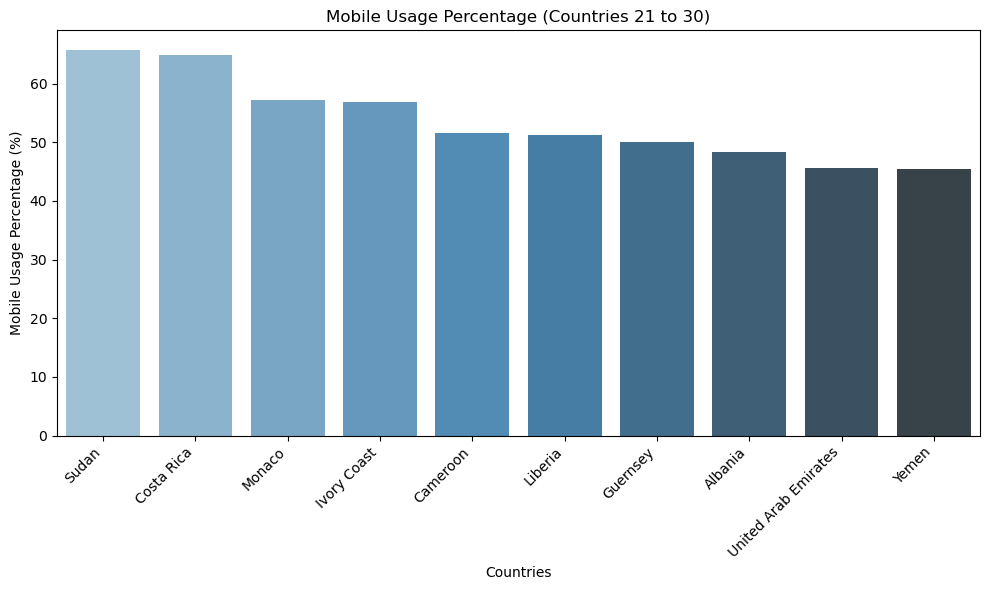

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


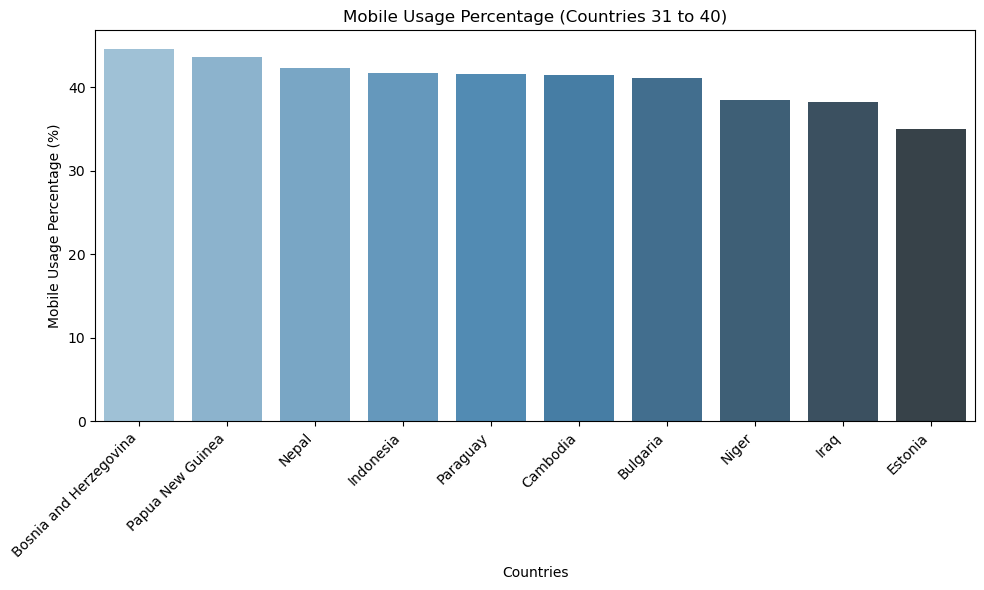

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


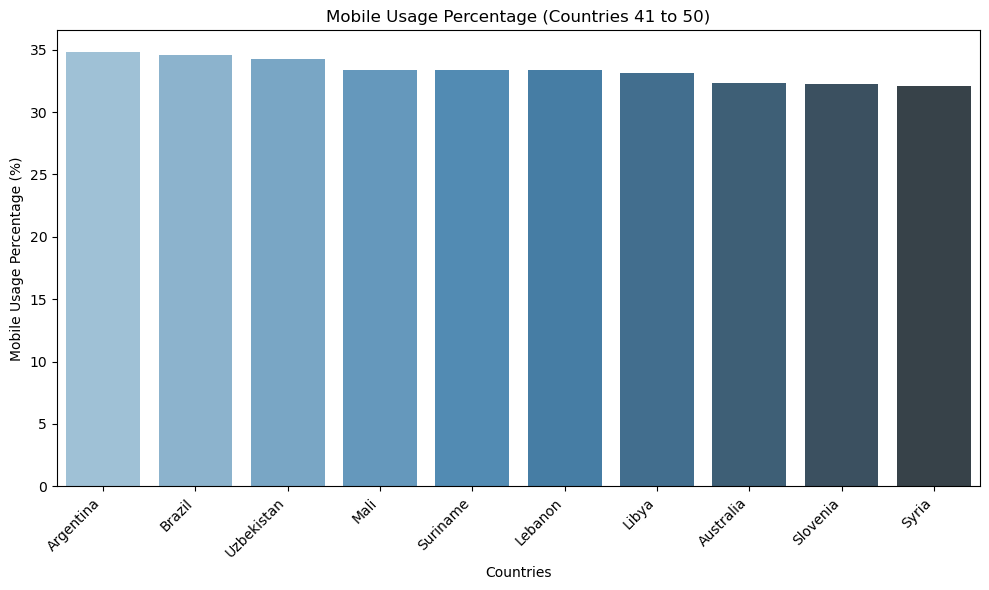

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


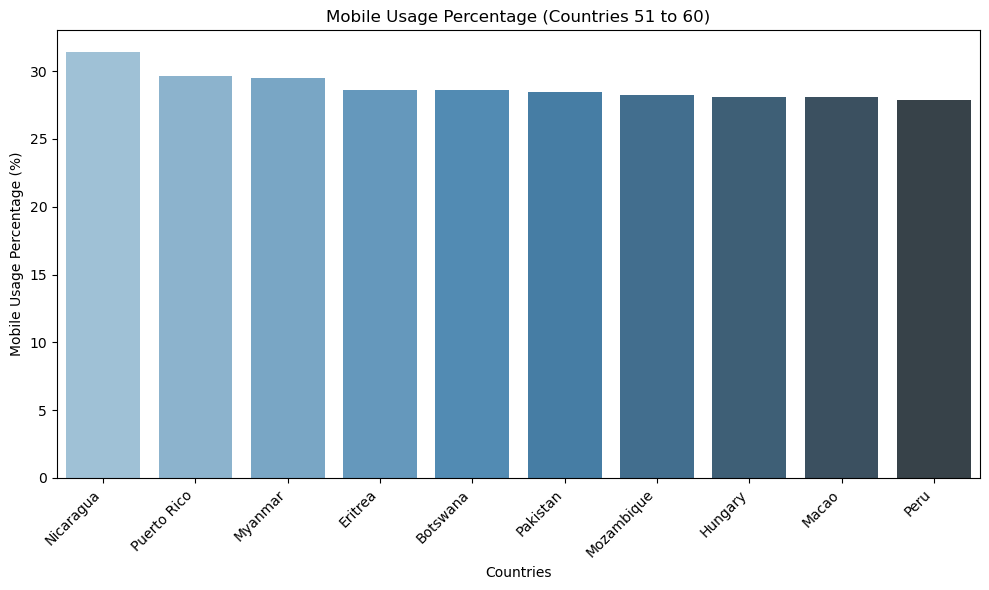

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


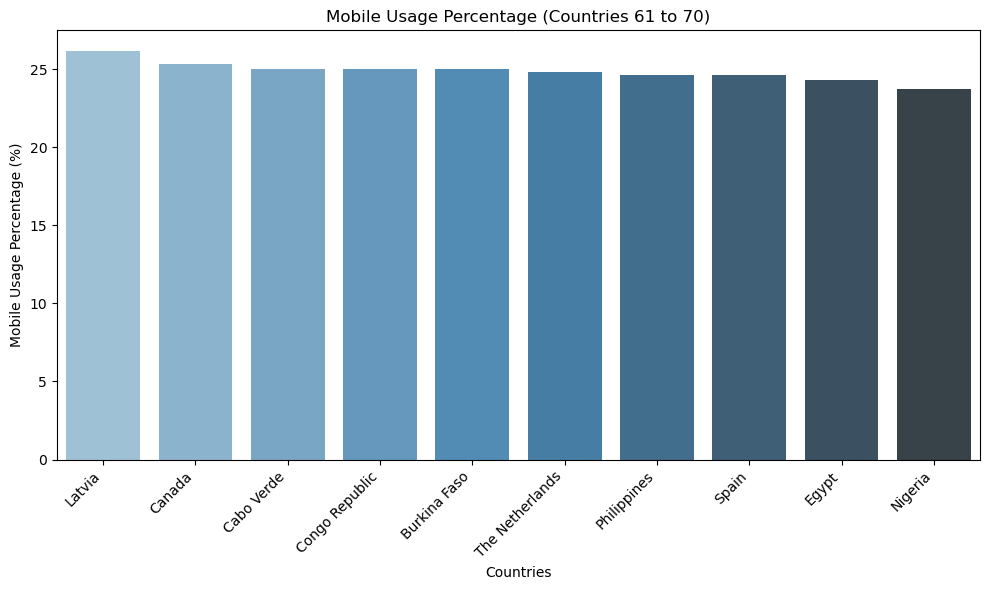

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


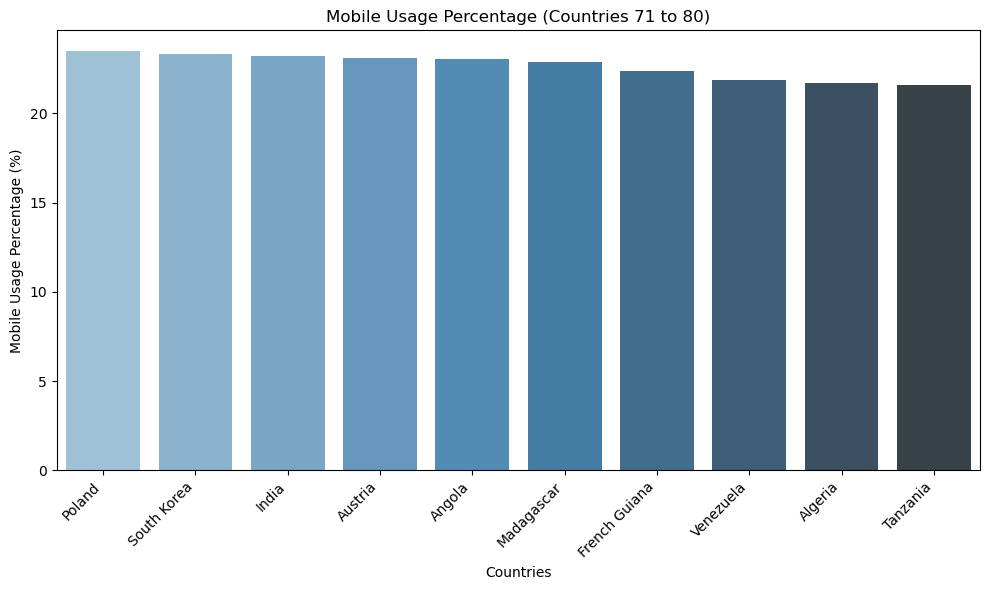

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


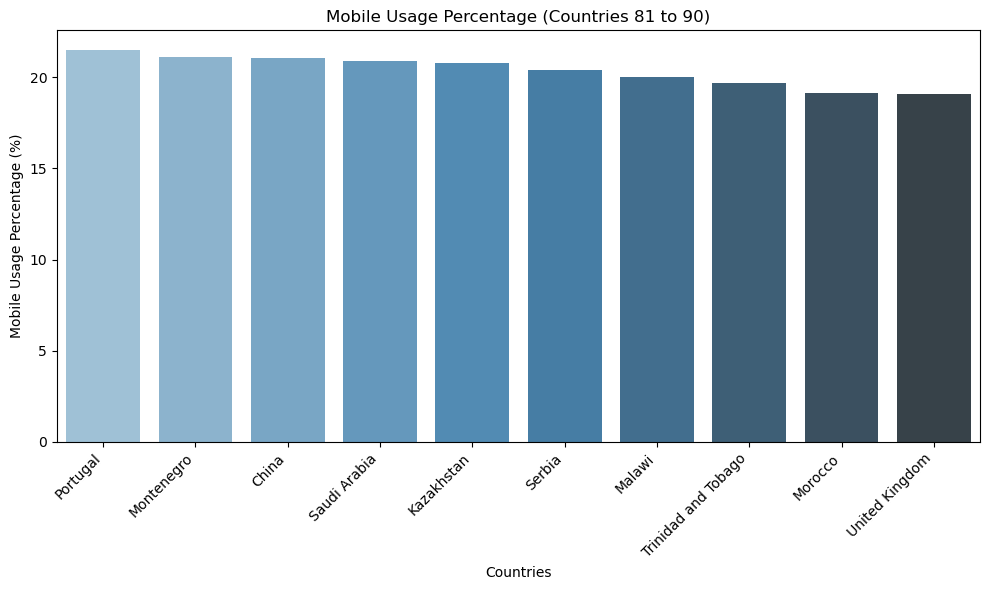

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


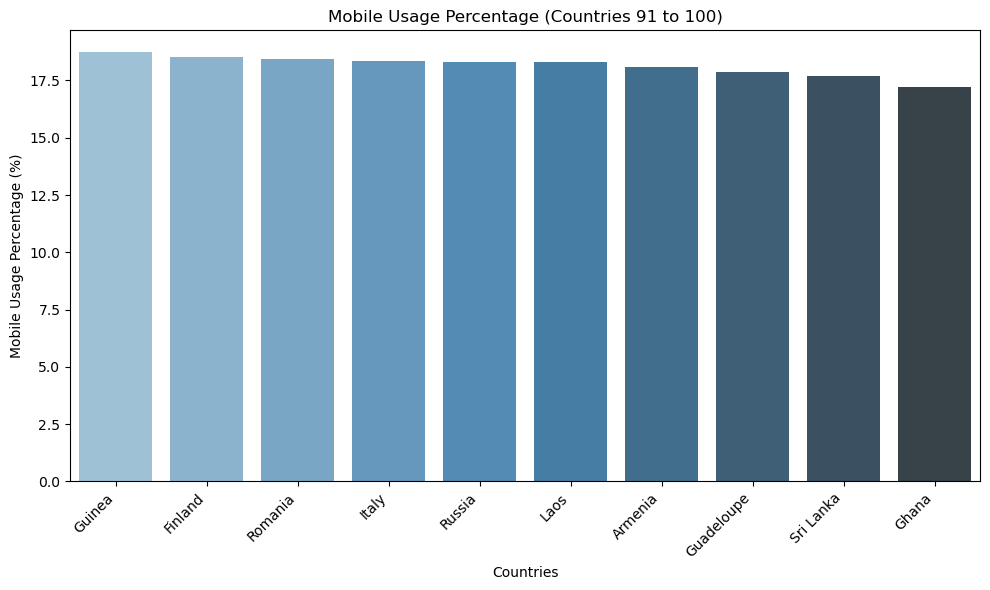

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


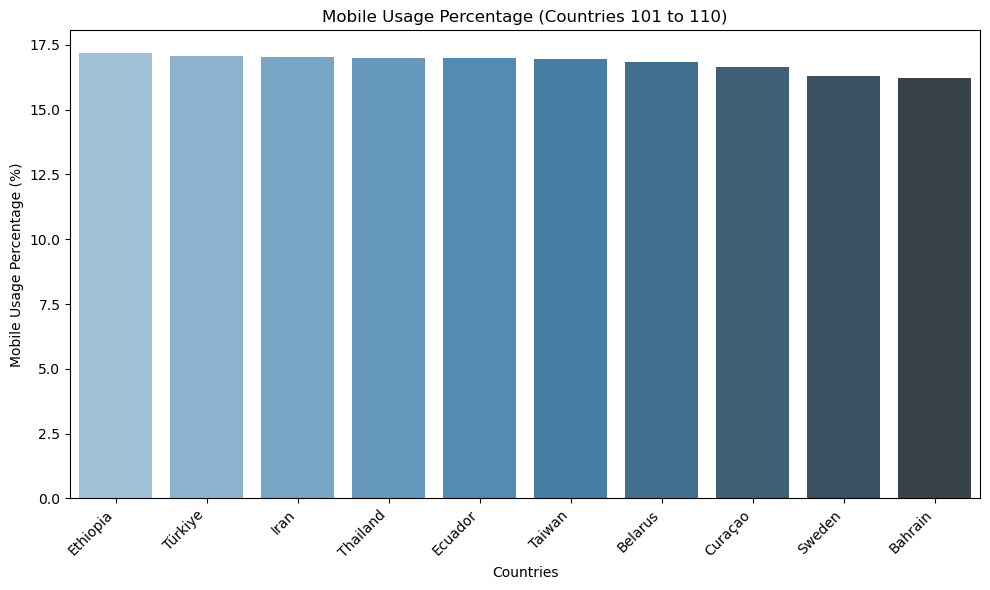

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


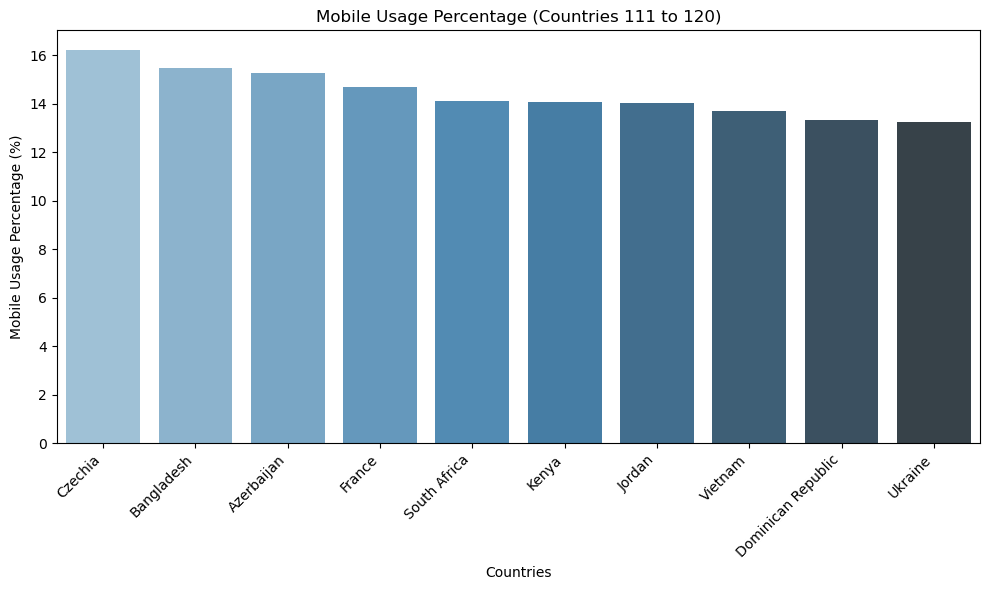

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


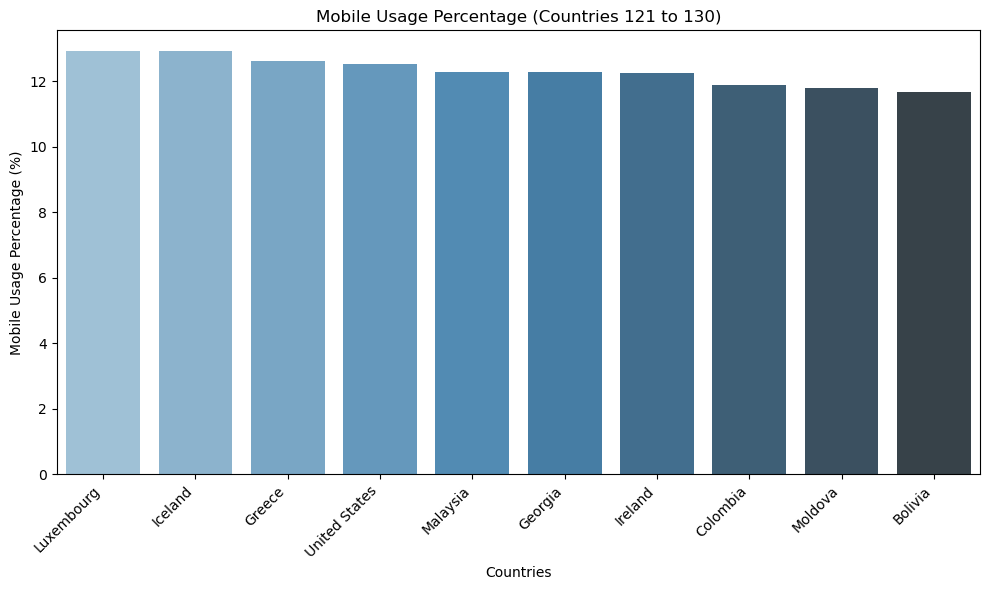

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


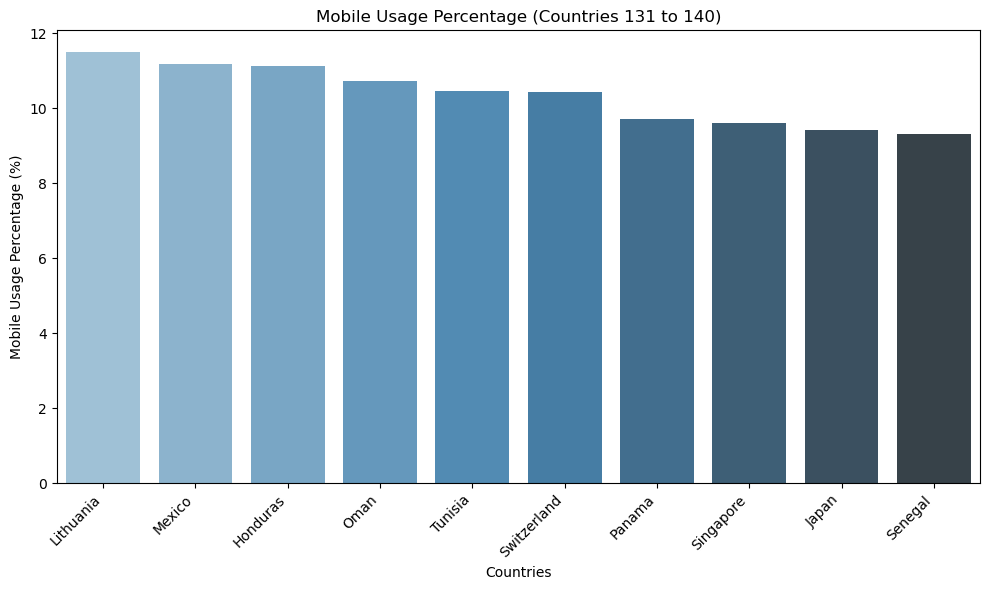

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


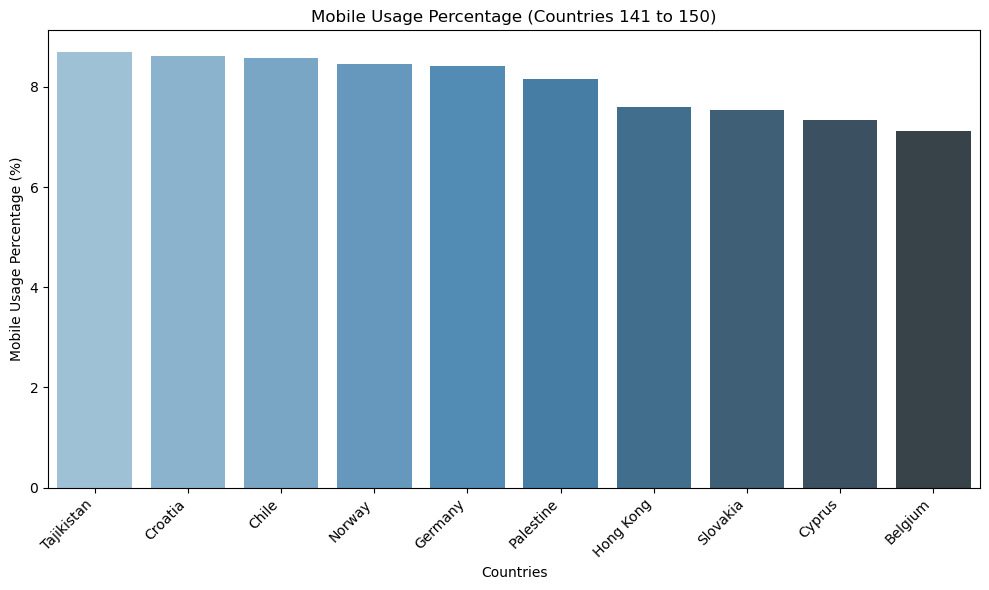

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


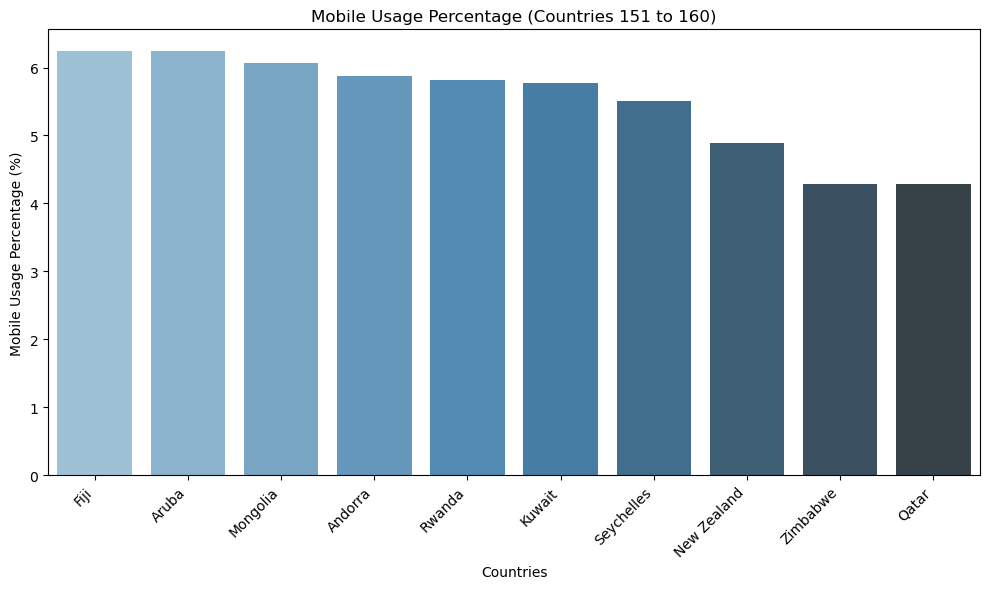

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


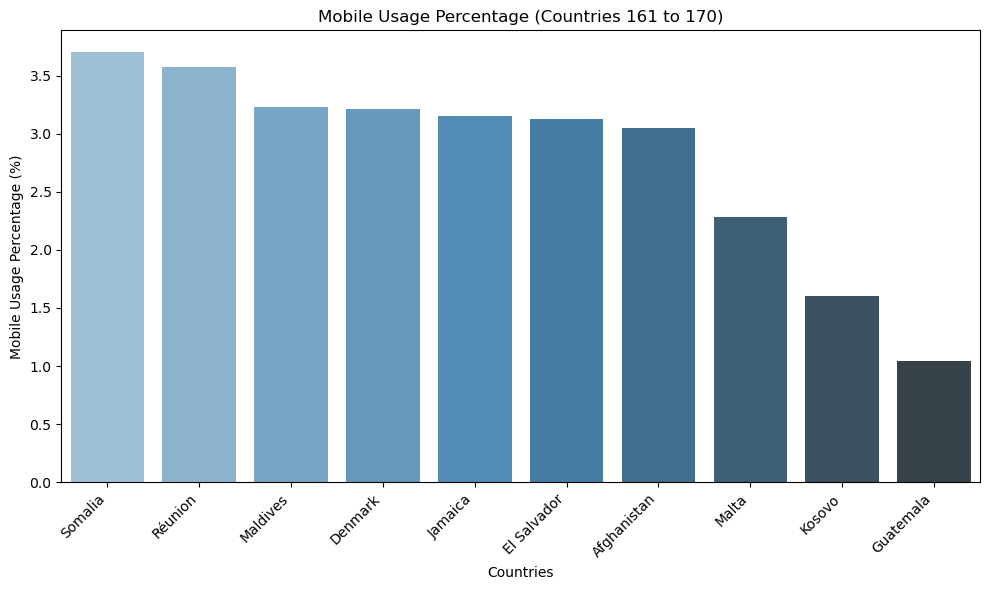

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


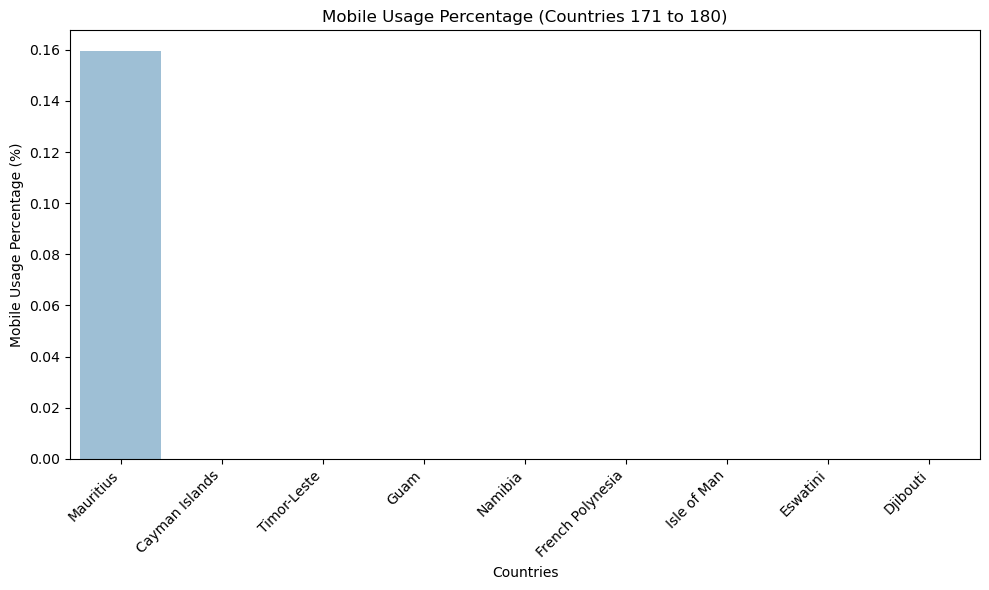

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


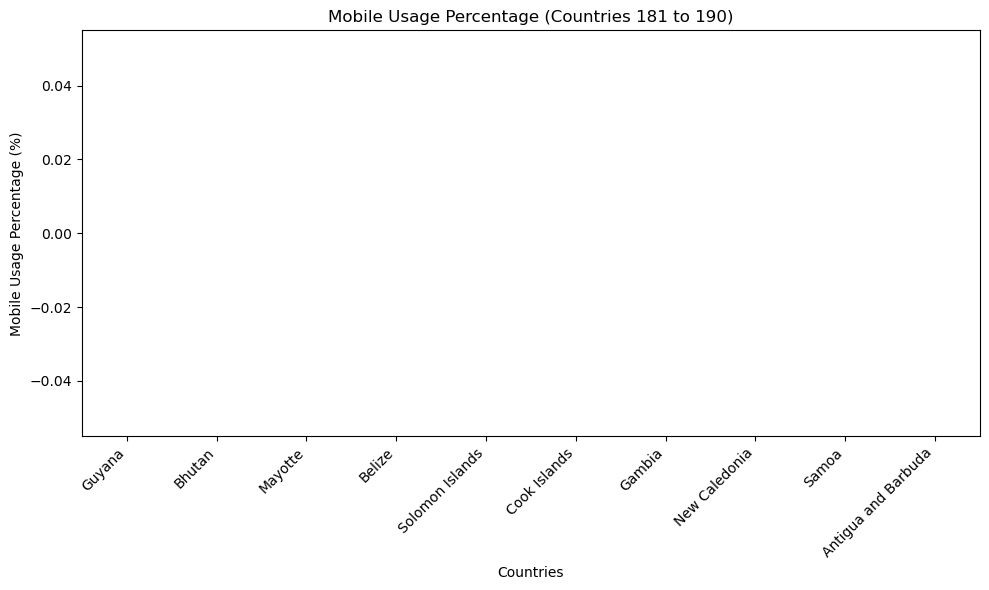

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


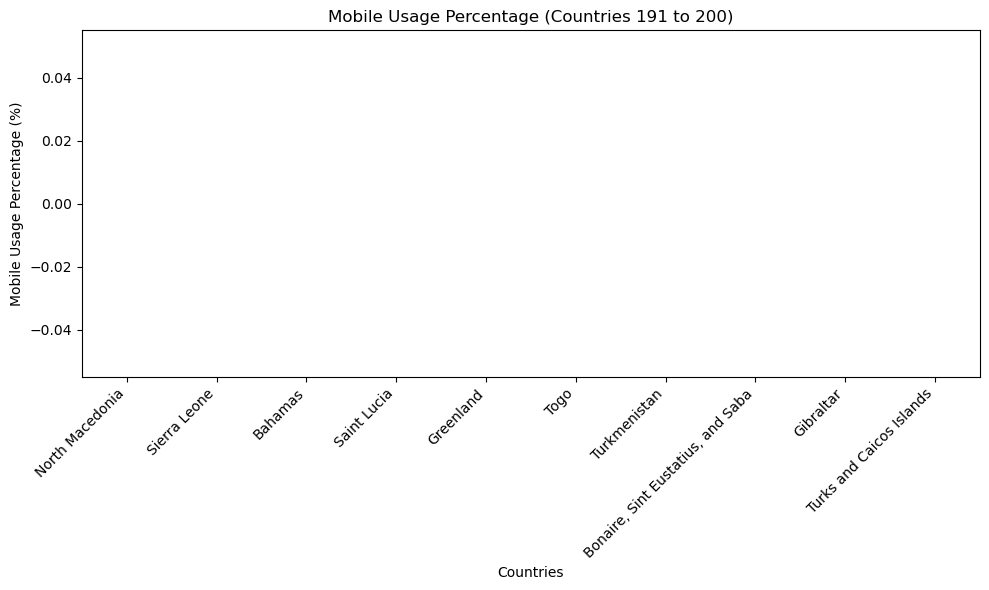

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1604903603.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


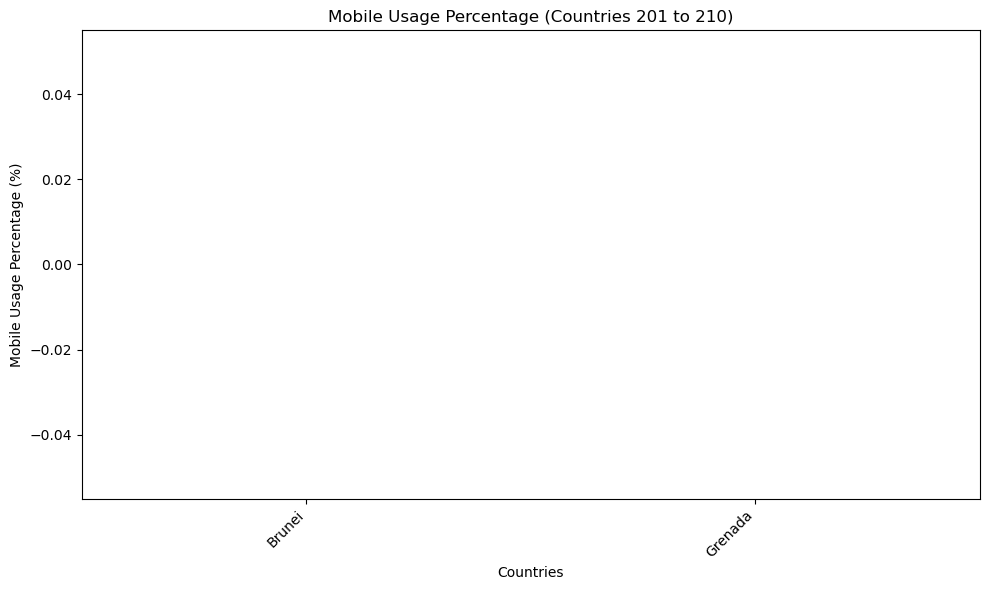

In [17]:
# Histogram of mobile usage percentage
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas
device_by_country_pivot_pd = device_by_country_pivot.select("country", "mobile_percentage").toPandas()

# Sort countries by mobile_percentage for better visibility
device_by_country_pivot_pd = device_by_country_pivot_pd.sort_values(by="mobile_percentage", ascending=False)

# Number of countries per plot
num_countries_per_plot = 10

# Split countries into groups of 10
num_plots = len(device_by_country_pivot_pd) // num_countries_per_plot + (1 if len(device_by_country_pivot_pd) % num_countries_per_plot > 0 else 0)

# Create multiple plots
for i in range(num_plots):
    # Subset of countries for each plot
    subset = device_by_country_pivot_pd.iloc[i*num_countries_per_plot : (i+1)*num_countries_per_plot]
    
    # Create a plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")
    
    # Add labels and a title
    plt.title(f"Mobile Usage Percentage (Countries {i*num_countries_per_plot+1} to {(i+1)*num_countries_per_plot})")
    plt.xlabel("Countries")
    plt.ylabel("Mobile Usage Percentage (%)")
    plt.xticks(rotation=45, ha="right")
    
    # Display the plot
    plt.tight_layout()
    plt.show()


/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/877533523.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


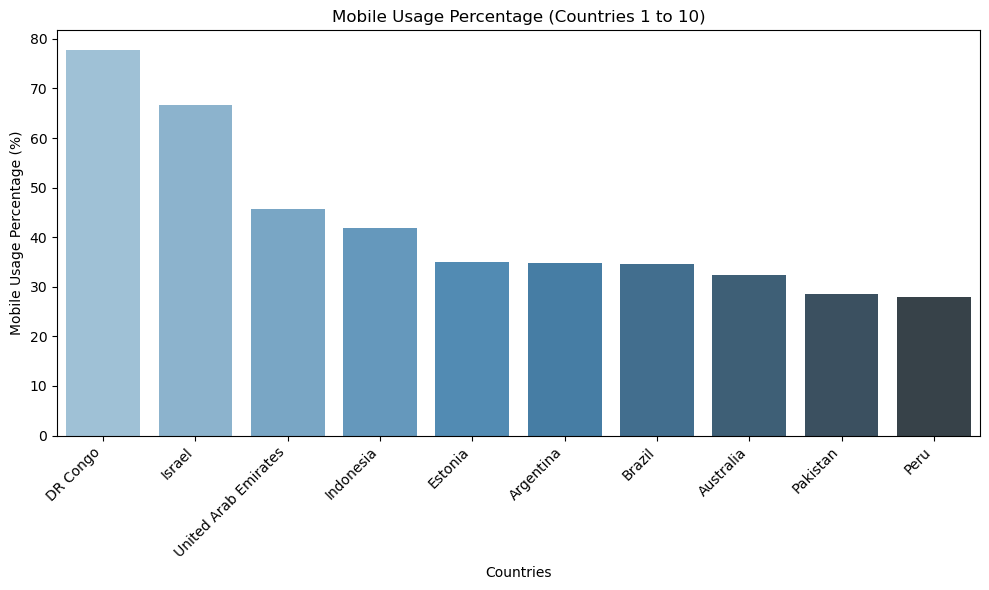

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/877533523.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


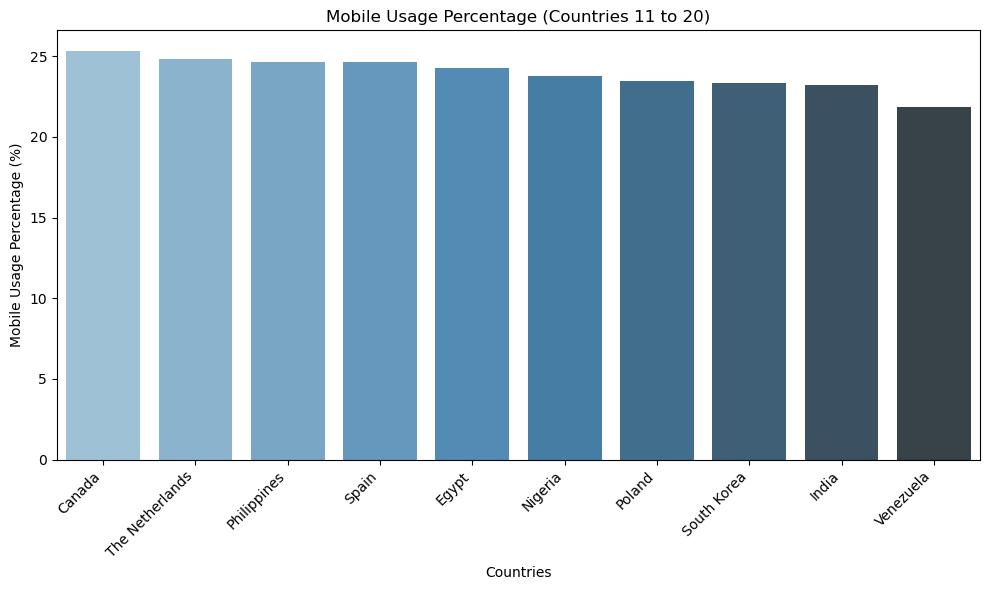

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/877533523.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


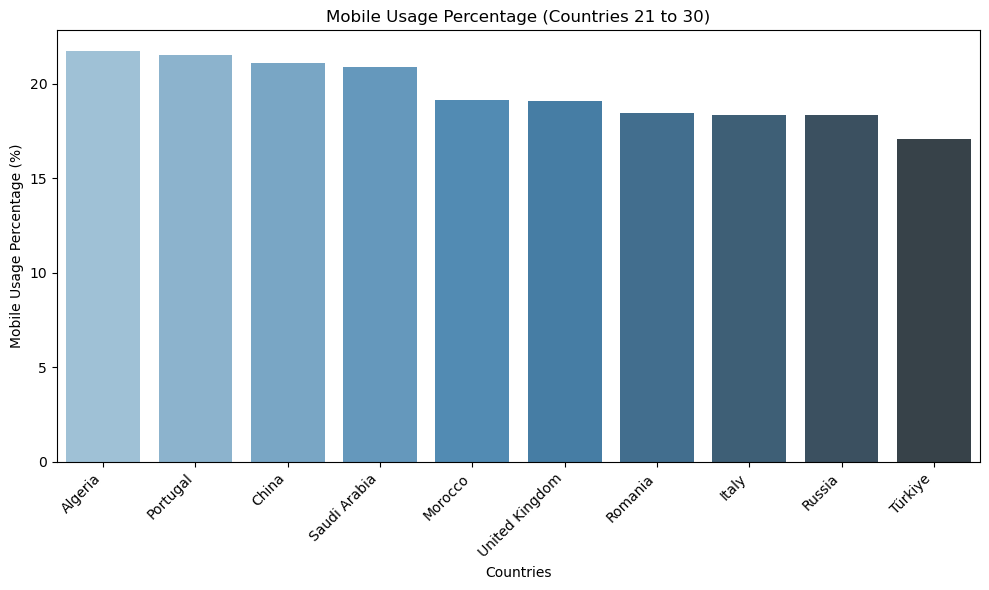

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/877533523.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


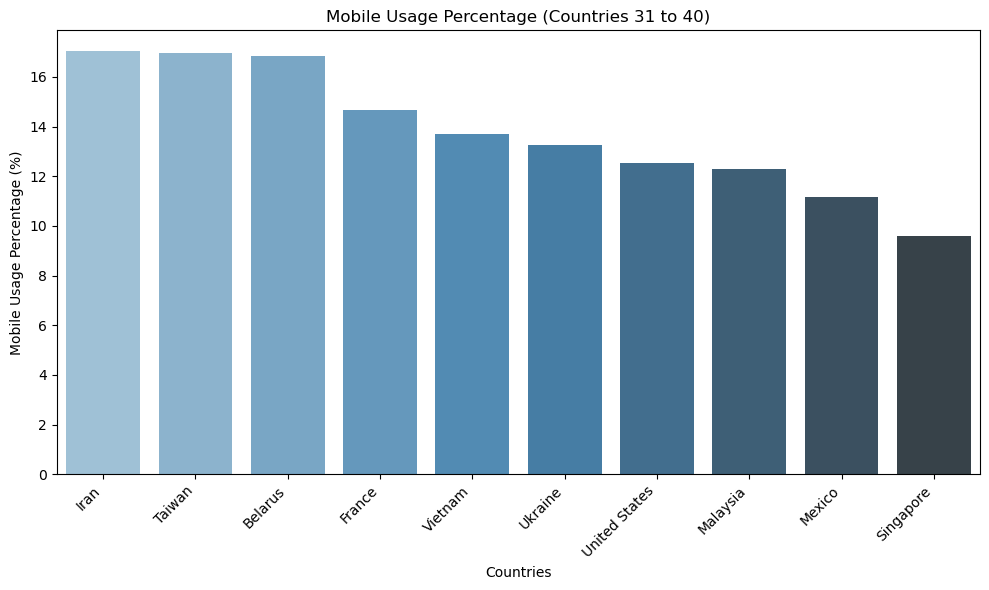

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/877533523.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")


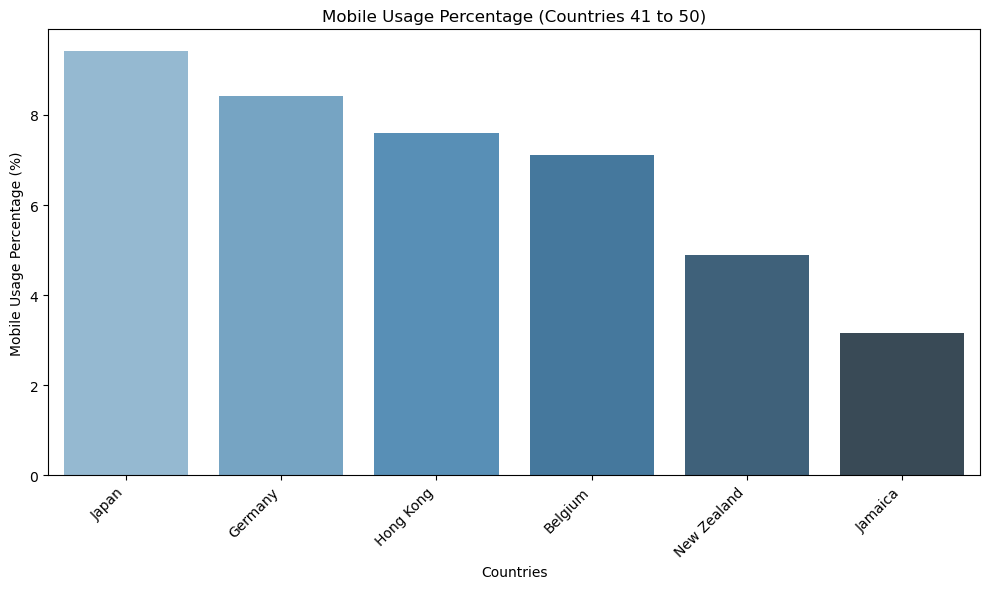

In [40]:
# Leave out some countries if the number of conversations is not enough
# Count the number of conversations per country
country_counts = a_df.groupBy("country").count()

# Filter countries with more than 2000 conversations
country_counts_filtered = country_counts.filter(country_counts["count"] > 2000)

# Retrieve the filtered countries as a list
valid_countries = [row['country'] for row in country_counts_filtered.collect()]

# Filter the original DataFrame to keep only these countries
device_by_country_pivot_pd_filtered = device_by_country_pivot_pd[device_by_country_pivot_pd['country'].isin(valid_countries)]

# Sort the filtered countries by percentage
device_by_country_pivot_pd_filtered = device_by_country_pivot_pd_filtered.sort_values(by="mobile_percentage", ascending=False)

# Create the plots as before
num_plots = len(device_by_country_pivot_pd_filtered) // num_countries_per_plot + (1 if len(device_by_country_pivot_pd_filtered) % num_countries_per_plot > 0 else 0)

for i in range(num_plots):
    # Subset of countries for each plot
    subset = device_by_country_pivot_pd_filtered.iloc[i*num_countries_per_plot : (i+1)*num_countries_per_plot]
    
    # Create a plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="country", y="mobile_percentage", data=subset, palette="Blues_d")
    
    # Add labels and a title
    plt.title(f"Mobile Usage Percentage (Countries {i*num_countries_per_plot+1} to {(i+1)*num_countries_per_plot})")
    plt.xlabel("Countries")
    plt.ylabel("Mobile Usage Percentage (%)")
    plt.xticks(rotation=45, ha="right")
    
    # Display the plot
    plt.tight_layout()
    plt.show()


In [41]:
pip install geopandas shapely


Note: you may need to restart the kernel to use updated packages.


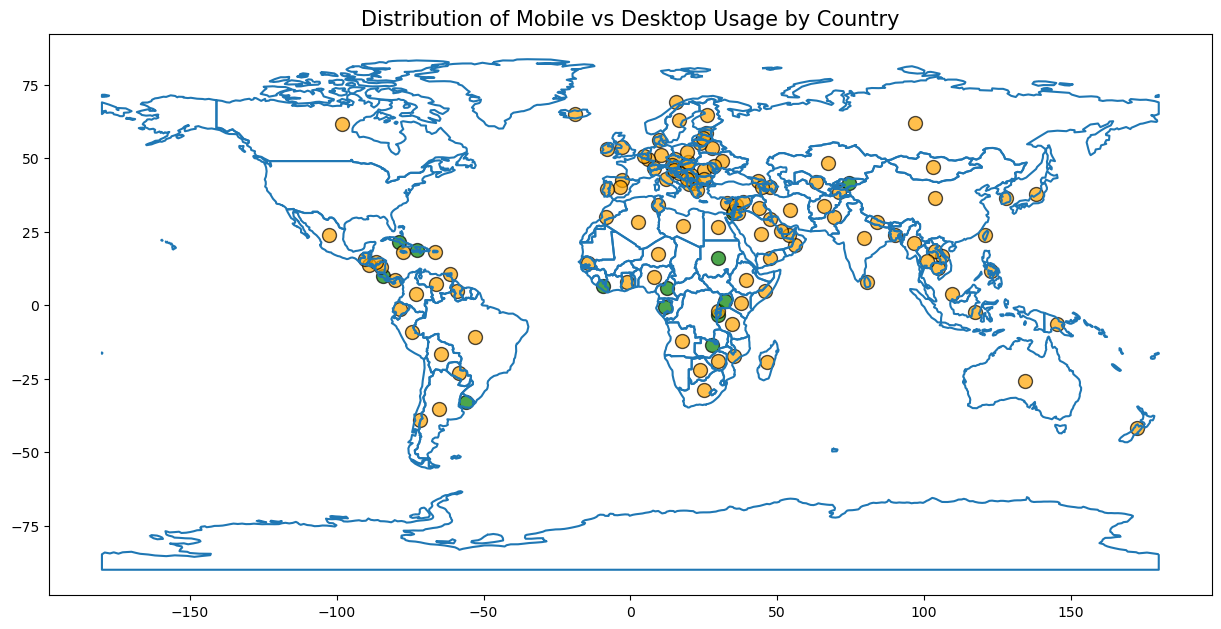

In [38]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np  # Pour vérifier les valeurs NaN

# Load the world map from a GeoJSON file
world = gpd.read_file("/Users/hamzaboukhriss/Desktop/Bigdata/planet.json")

# Convert the PySpark DataFrame to Pandas (make sure it contains the 'country' and 'mobile_percentage' columns)
device_by_country_pivot_pd_filtered = device_by_country_pivot_pd[device_by_country_pivot_pd['country'].isin(valid_countries)]

# Sort the filtered countries by percentage
device_by_country_pivot_pd_filtered = device_by_country_pivot_pd_filtered.sort_values(by="mobile_percentage", ascending=False)

# Merge the geographic data with the percentage data
merged = world.set_index('name').join(device_by_country_pivot_pd_filtered.set_index('country'))

# Create a plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the world map boundary
world.boundary.plot(ax=ax)

# Add circles based on mobile usage percentage
for idx, row in merged.iterrows():
    # Skip if 'mobile_percentage' is NaN
    if np.isnan(row['mobile_percentage']):
        continue

    # Condition: green for more mobiles, red for more desktops
    if row['mobile_percentage'] > 50:
        color = 'green'
    else:
        color = 'orange'
    
    # Plot a circle on the country with a size based on the mobile percentage
    ax.scatter(row['geometry'].centroid.x, row['geometry'].centroid.y, color=color, s=100, edgecolor='black', alpha=0.7)

# Add a title
ax.set_title("Distribution of Mobile vs Desktop Usage by Country", fontsize=15)

# Display the plot
plt.show()


In [46]:
#group by continent (and do the same thing) 
!pip install pycountry-convert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 25.6 MB/s eta 0:00:00a 0:00:01


In [50]:
from pyspark.sql.functions import col, sum as Fsum, expr

# Ajouter une colonne pour le continent à partir des pays
device_by_country_pivot = device_by_country_pivot.withColumn(
    "continent", 
    country_to_continent_udf(col("country"))
)

# Vérifier que les colonnes mobile et desktop sont correctement définies
device_by_country_pivot = device_by_country_pivot.withColumn(
    "total_devices",
    expr("mobile + desktop")  # Calculer la somme des appareils par pays
)

# Calculer les pourcentages d'utilisation de mobile et desktop
device_by_country_pivot = device_by_country_pivot.withColumn(
    "mobile_percentage",
    (col("mobile") / col("total_devices") * 100).cast("double")
).withColumn(
    "desktop_percentage",
    (col("desktop") / col("total_devices") * 100).cast("double")
)

# Filtrer les lignes où total_devices est valide pour éviter les erreurs de division
device_by_country_pivot = device_by_country_pivot.filter(col("total_devices") > 0)

# Agréger les données par continent
device_usage_by_continent = (
    device_by_country_pivot.groupBy("continent")
    .agg(
        Fsum("mobile").alias("total_mobile"),
        Fsum("desktop").alias("total_desktop"),
        Fsum("total_devices").alias("total_devices")
    )
    .withColumn(
        "mobile_percentage",
        (col("total_mobile") / col("total_devices") * 100).cast("double")
    )
    .withColumn(
        "desktop_percentage",
        (col("total_desktop") / col("total_devices") * 100).cast("double")
    )
)

# Afficher les résultats agrégés par continent
device_usage_by_continent.show()


+-------------+------------+-------------+-------------+-------------------+------------------+
|    continent|total_mobile|total_desktop|total_devices|  mobile_percentage|desktop_percentage|
+-------------+------------+-------------+-------------+-------------------+------------------+
|       Europe|       56834|       271445|       328279| 17.312712662095354| 82.68728733790465|
|       Africa|       14909|        30650|        45559|  32.72459887179262| 67.27540112820738|
|         NULL|         259|      1000947|      1001206|0.02586880222451723| 99.97413119777548|
|North America|       31867|       199447|       231314| 13.776511581659562| 86.22348841834044|
|South America|        9212|        20789|        30001| 30.705643145228496| 69.29435685477151|
|      Oceania|        3146|        10792|        13938| 22.571387573539965| 77.42861242646003|
|         Asia|       53586|       231468|       285054| 18.798543433875686|  81.2014565661243|
+-------------+------------+------------

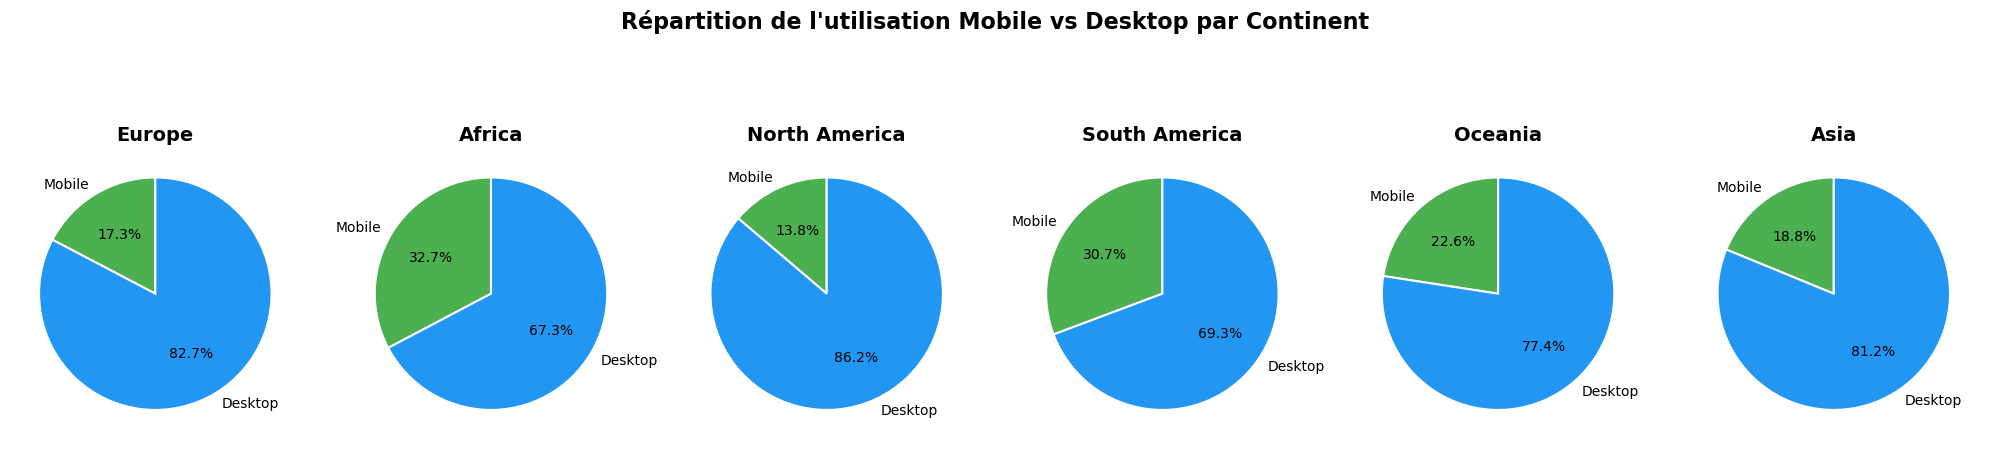

In [54]:
# Convertir en Pandas pour la visualisation
device_usage_pd = device_usage_by_continent.toPandas()

# Vérifier qu'il y a des données valides
if not device_usage_pd.empty:
    # Palette de couleurs pour les diagrammes
    color_palette = {
        "Mobile": "#4CAF50",  # Vert élégant
        "Desktop": "#2196F3",  # Bleu clair
    }

    # Créer les diagrammes circulaires
    fig, ax = plt.subplots(1, len(device_usage_pd["continent"].dropna().unique()), figsize=(20, 5))
    
    for i, continent in enumerate(device_usage_pd["continent"].dropna().unique()):
        continent_data = device_usage_pd[device_usage_pd["continent"] == continent]
        percentages = [
            continent_data["mobile_percentage"].values[0],
            continent_data["desktop_percentage"].values[0],
        ]
        labels = ["Mobile", "Desktop"]
        colors = [color_palette["Mobile"], color_palette["Desktop"]]
        
        ax[i].pie(
            percentages, 
            labels=labels, 
            autopct='%1.1f%%', 
            colors=colors, 
            startangle=90,
            wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},  # Bords blancs pour un effet propre
        )
        ax[i].set_title(continent, fontsize=14, fontweight="bold")
        ax[i].set_aspect("equal")  # Assure une belle forme circulaire

    plt.suptitle("Répartition de l'utilisation Mobile vs Desktop par Continent", fontsize=16, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()
else:
    print("Aucune donnée valide pour la visualisation.")


/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/3051390971.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world_continents['centroid'] = world_continents.geometry.centroid


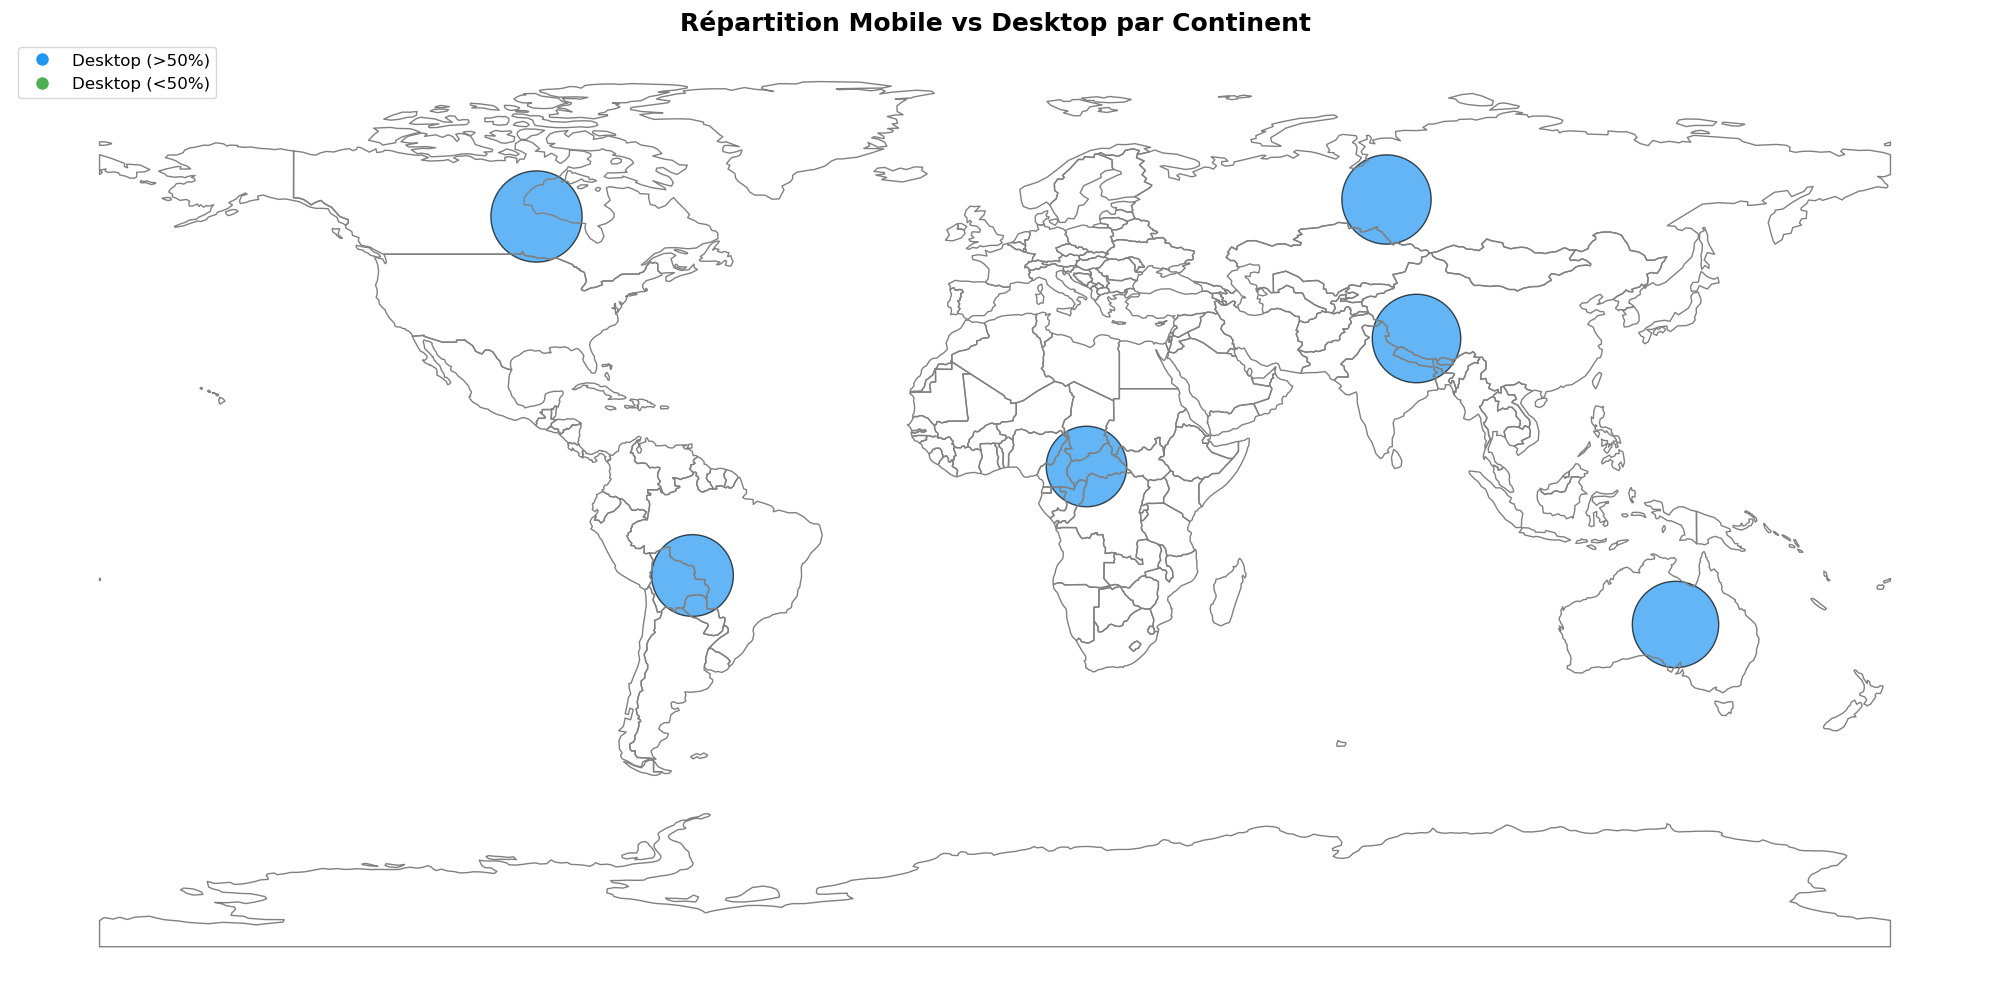

In [62]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

# Charger le fichier GeoJSON des pays/continents depuis "planet.json"
world = gpd.read_file("/Users/hamzaboukhriss/Desktop/Bigdata/planet.json")

# Assurer la correspondance entre les noms de continents et les données
continent_map = {
    'Africa': 'Africa',
    'Asia': 'Asia',
    'Europe': 'Europe',
    'North America': 'North America',
    'South America': 'South America',
    'Oceania': 'Oceania'
}

# Mapper les continents dans le DataFrame
world['continent'] = world['continent'].map(continent_map)

# Calculer les centroids pour chaque continent
world_continents = world.dissolve(by="continent", as_index=False)
world_continents['centroid'] = world_continents.geometry.centroid

# Convertir les données Spark en Pandas pour la fusion
device_usage_pd = device_usage_by_continent.toPandas()

# Fusionner les données géographiques et les données d'utilisation mobile/desktop
merged = world_continents.merge(
    device_usage_pd, 
    left_on="continent", 
    right_on="continent", 
    how="inner"
)

# Couleurs pour les cercles (vert pour mobile, bleu pour desktop)
cmap = ListedColormap(["#4CAF50", "#2196F3"])

# Créer la figure
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

# Tracer les frontières des continents
world.boundary.plot(ax=ax, linewidth=1, edgecolor='gray')

# Ajouter des cercles sur les centroids des continents
for idx, row in merged.iterrows():
    # Taille des cercles proportionnelle à l'utilisation desktop (avec facteur d'échelle augmenté)
    size = row['desktop_percentage'] * 50  # Augmenter le facteur d'échelle pour les cercles plus gros
    ax.scatter(
        row['centroid'].x, 
        row['centroid'].y, 
        s=size, 
        color=cmap(1 if row['desktop_percentage'] > 50 else 0),  # Bleu pour plus de desktop, vert pour mobile
        alpha=0.7, 
        edgecolor="black",
    )

# Créer une légende avec des cercles proportionnels réduits
legend_labels = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2196F3', markersize=10, label='Desktop (>50%)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#4CAF50', markersize=10, label='Desktop (<50%)')
]

# Ajouter une légende plus petite
ax.legend(handles=legend_labels, loc='upper left', fontsize=12)

# Ajouter un titre
ax.set_title("Répartition Mobile vs Desktop par Continent", fontsize=18, fontweight="bold")
ax.axis("off")  # Supprimer les axes pour une carte plus propre

# Afficher la carte
plt.tight_layout()
plt.show()


In [ ]:
#How do conversation patterns vary across different device types?

In [72]:
from pyspark.sql import functions as F

# Ajouter la colonne "total_devices"
a_df = a_df.withColumn(
    "total_devices", 
    F.when(F.col("device_type") == "mobile", 1).otherwise(0) +
    F.when(F.col("device_type") == "desktop", 1).otherwise(0)
)

# Ajouter la colonne "mobile_percentage"
a_df = a_df.withColumn(
    "mobile_percentage", 
    (F.when(F.col("device_type") == "mobile", 1).otherwise(0) / F.col("total_devices") * 100).cast("double")
)

# Ajouter la colonne "desktop_percentage"
a_df = a_df.withColumn(
    "desktop_percentage", 
    (100 - F.col("mobile_percentage")).cast("double")
)

# Vérifier les nouvelles colonnes
a_df.select("device_type", "mobile_percentage", "desktop_percentage").show(5)
a_df.show(5)


+-----------+-----------------+------------------+
|device_type|mobile_percentage|desktop_percentage|
+-----------+-----------------+------------------+
|    desktop|              0.0|             100.0|
|    desktop|              0.0|             100.0|
|    desktop|              0.0|             100.0|
|    desktop|              0.0|             100.0|
|    desktop|              0.0|             100.0|
+-----------+-----------------+------------------+
only showing top 5 rows

+--------------------+------------------+-------------------+---------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+---------------+-----------+-------------+-----------------+------------------+
|   conversation_hash|             model|          timestamp|                     conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|        state|        country|  

In [74]:
# Calcul du nombre de conversations par type d'appareil
conversation_count = a_df.groupBy("device_type").count()

# Afficher les résultats
conversation_count.show()


+-----------+-------+
|device_type|  count|
+-----------+-------+
|    desktop|1765538|
|     mobile| 169813|
+-----------+-------+



In [78]:
# Convertir la colonne 'toxic' en valeurs numériques (1 pour True, 0 pour False)
a_df = a_df.withColumn("toxic_numeric", F.when(F.col("toxic") == True, 1).otherwise(0))

# Calcul du score moyen de toxicité par type d'appareil
toxic_score = a_df.groupBy("device_type").agg(
    F.avg("toxic_numeric").alias("avg_toxicity")
)

# Afficher les résultats
toxic_score.show()



+-----------+-------------------+
|device_type|       avg_toxicity|
+-----------+-------------------+
|    desktop|0.06440869581963118|
|     mobile|0.18254197264049277|
+-----------+-------------------+



In [84]:
# Calcul de la longueur moyenne des messages par type d'appareil
from pyspark.sql import functions as F

# Calculer la longueur de chaque message dans la conversation
a_df = a_df.withColumn("message_lengths", F.expr("transform(conversation, x -> length(x.content))"))

# Calcul de la longueur moyenne des messages par type d'appareil
avg_message_length = a_df.groupBy("device_type").agg(
    F.avg(F.size("message_lengths")).alias("avg_message_length")
)

# Afficher les résultats
avg_message_length.show()



+-----------+------------------+
|device_type|avg_message_length|
+-----------+------------------+
|    desktop| 4.503849818015811|
|     mobile| 4.889849422600154|
+-----------+------------------+



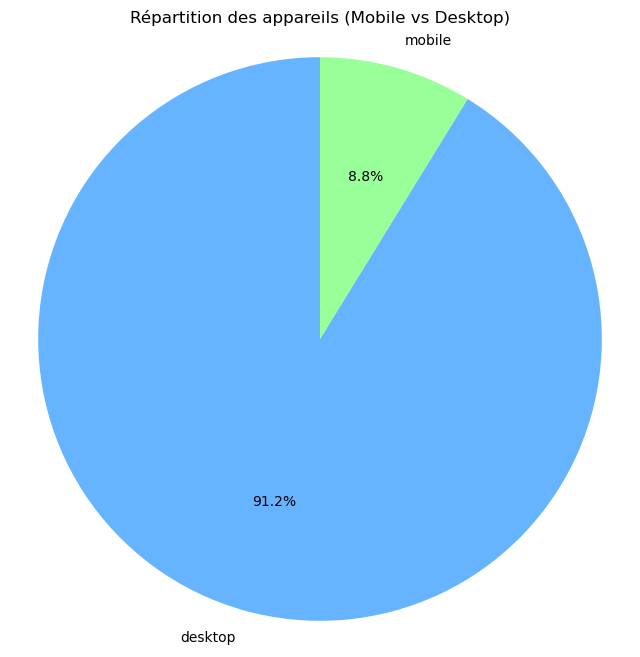

/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/2599309676.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='device_type', y='avg_toxicity', data=toxic_score_df, palette='viridis')


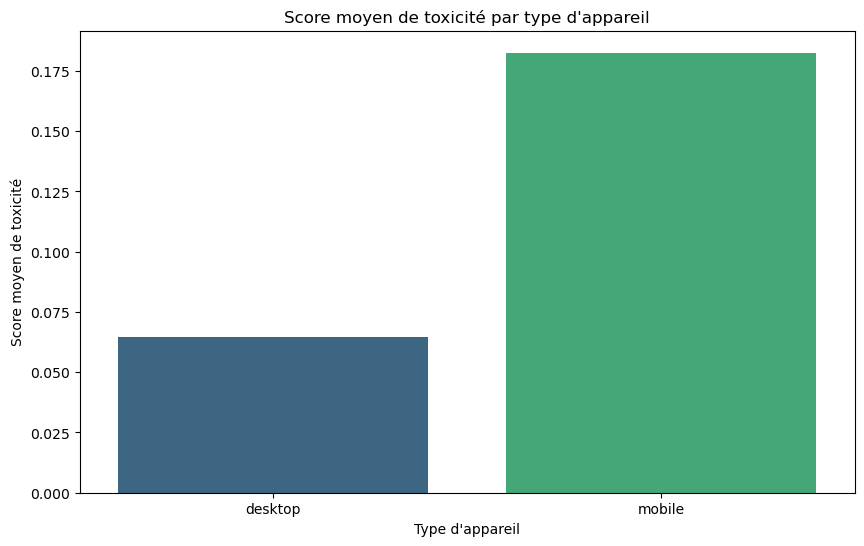

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Option 1: Diagramme circulaire pour la répartition des appareils
device_count = a_df.groupBy("device_type").count().toPandas()

# Plotting le diagramme circulaire
plt.figure(figsize=(8, 8))
plt.pie(device_count['count'], labels=device_count['device_type'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])
plt.title('Répartition des appareils (Mobile vs Desktop)')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()

# Option 2: Histogramme pour les scores moyens de toxicité par type d'appareil
toxic_score_df = toxic_score.toPandas()

# Plotting l'histogramme des scores moyens de toxicité
plt.figure(figsize=(10, 6))
sns.barplot(x='device_type', y='avg_toxicity', data=toxic_score_df, palette='viridis')
plt.title('Score moyen de toxicité par type d\'appareil')
plt.xlabel('Type d\'appareil')
plt.ylabel('Score moyen de toxicité')
plt.show()


/var/folders/79/3l99b_xd6bdff4s6tgvb3s_h0000gn/T/ipykernel_16067/1745821419.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='device_type', y='avg_message_length', data=avg_message_length_pd, palette="viridis")


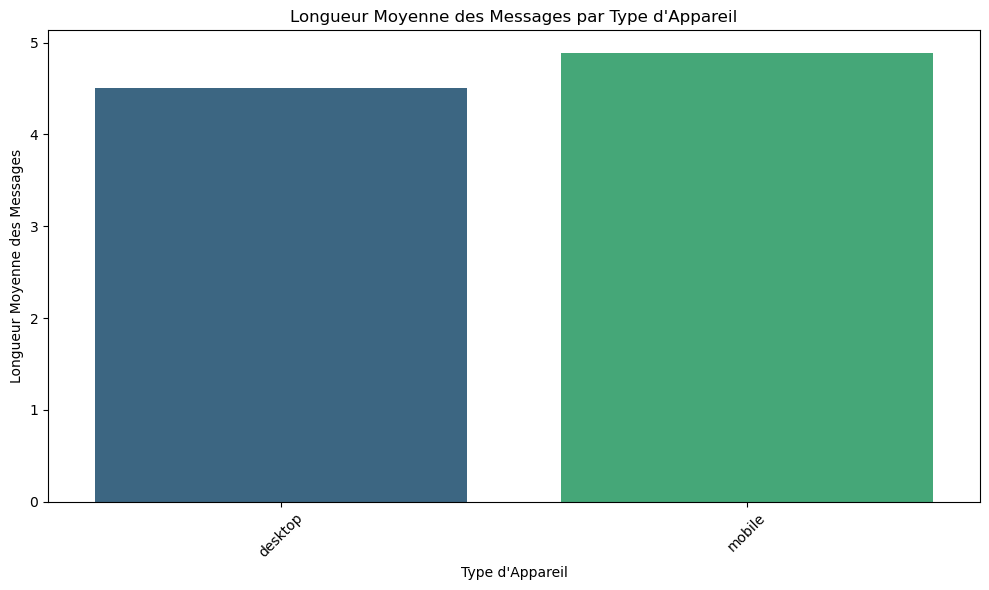

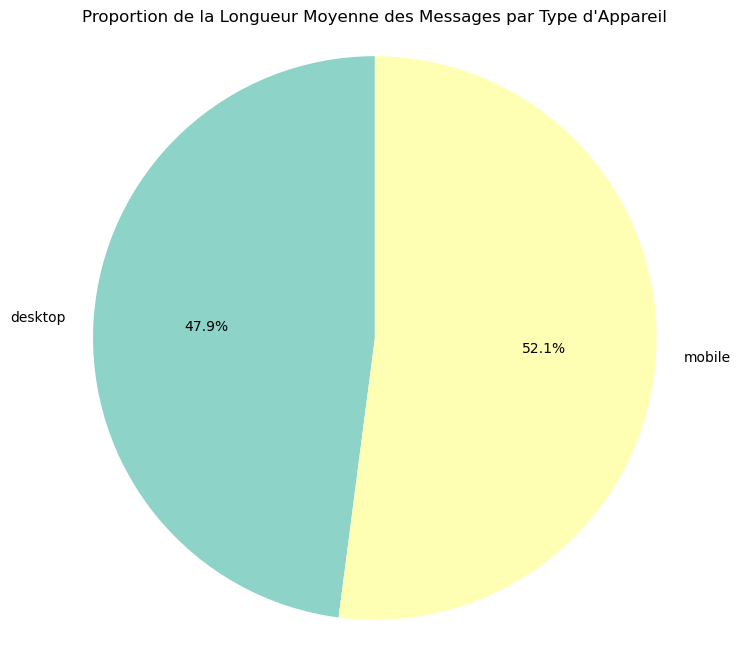

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Supposons que avg_message_length soit un DataFrame Pandas avec les données
# Vous devez d'abord convertir le DataFrame Spark en un DataFrame Pandas
avg_message_length_pd = avg_message_length.toPandas()

# Histogramme
plt.figure(figsize=(10, 6))
sns.barplot(x='device_type', y='avg_message_length', data=avg_message_length_pd, palette="viridis")
plt.title('Longueur Moyenne des Messages par Type d\'Appareil')
plt.xlabel('Type d\'Appareil')
plt.ylabel('Longueur Moyenne des Messages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Diagramme Circulaire
plt.figure(figsize=(8, 8))
plt.pie(avg_message_length_pd['avg_message_length'], labels=avg_message_length_pd['device_type'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3", len(avg_message_length_pd)))
plt.title('Proportion de la Longueur Moyenne des Messages par Type d\'Appareil')
plt.axis('equal')  # Pour avoir un cercle parfait
plt.show()

